In [1]:
%matplotlib inline
import seaborn as sns; 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import gridspec
import scipy
style.use('fast')
from datetime import datetime
from io import StringIO
import re
import numpy as np
from datetime import datetime
import os


In [2]:
sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22
flatui = [sns.xkcd_rgb["medium green"], "orange", sns.xkcd_rgb["medium purple"], "#e74c3c", "#34495e", "#2ecc71"]


In [3]:
# Cliff's Delta
from __future__ import division
 
def cliffsDelta(lst1,lst2,
                dull = [0.147, # small
                        0.33,  # medium
                        0.474 # large
                        ][0] ): 
  "Returns true if there are more than 'dull' differences"
  m, n = len(lst1), len(lst2)
  lst2 = sorted(lst2)
  j = more = less = 0
  for repeats,x in runs(sorted(lst1)):
    while j <= (n - 1) and lst2[j] <  x: 
      j += 1
    more += j*repeats
    while j <= (n - 1) and lst2[j] == x: 
      j += 1
    less += (n - j)*repeats
  d= (more - less) / (m*n)
  f=abs(d)  > dull
  print("d="+str(d))#+' '+str(f))
  return abs(d)  > dull
   
def runs(lst):
  "Iterator, chunks repeated values"
  for j,two in enumerate(lst):
    if j == 0:
      one,i = two,0
    if one!=two:
      yield j - i,one
      i = j
    one=two
  yield j - i + 1,two
  
def _cliffsDelta():
  "demo function"
  lst1=[1,2,3,4,5,6,7]
  for r in [1.01,1.1,1.21, 1.5, 2]:
    lst2=map(lambda x: x*r,lst1)

# RQ3
# BUGS WITH THE INSTALLED PACKAGES


In [4]:
# Vulnerabilities: So we can filter them out
docker_vulnerabilities=pd.read_csv('../../docker/csv/used/docker_vulnerabilities.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
docker_vulnerabilities['urgency']=docker_vulnerabilities['urgency'].apply(lambda x: 'not assigned' if 'not' in x
                                                                        else x)
docker_vulnerabilities['urgency']=docker_vulnerabilities['urgency'].apply(lambda x: x.split('*')[0])
docker_vulnerabilities.drop_duplicates(inplace=True)
len(docker_vulnerabilities)

25686

In [5]:
# BUGS
docker_bugs=pd.read_csv('../../docker/csv/docker_bugs_MAI_checked.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
docker_bugs.drop_duplicates(inplace=True)
bug_order=['wishlist','minor','normal','important','serious','grave','critical']
docker_bugs=docker_bugs.query('status!="fixed" and status!="pending-fixed"')
docker_bugs['status']=docker_bugs['status'].apply(lambda x: "fixed" if x =="done" else x)
len(docker_bugs)

47604

In [6]:
# considering only security bugs
mask = docker_bugs['debianbug'].isin(docker_vulnerabilities.query('status=="resolved"')['debianbug'].drop_duplicates())
security_only=docker_bugs[mask]
print(len(security_only['debianbug'].drop_duplicates()),len(docker_vulnerabilities.query('status=="resolved"')['debianbug'].drop_duplicates()))

70 708


In [7]:
# NOT considering security bugs
mask = docker_bugs['debianbug'].isin(docker_vulnerabilities['debianbug'].drop_duplicates())
docker_bugs=docker_bugs[~mask]
len(docker_bugs)

47245

In [8]:
docker_bugs['severity']=docker_bugs['severity'].apply(lambda x:
                                                     'high' if x=="grave"
                                                     else 'high' if x=="serious"
                                                     else 'high' if x=="critical"
                                                     else x)

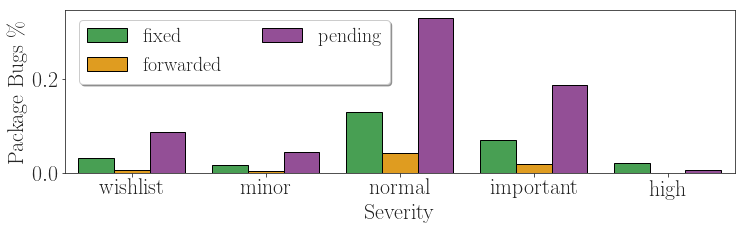

In [9]:
df_bug=docker_bugs.groupby(['severity','status']).count().reset_index()
df_bug['source']=df_bug['source']/len(docker_bugs)
df_bug=df_bug.sort_values('severity', ascending=False)

ax = sns.barplot(x="severity", 
                 y="source", 
                 hue="status", 
                 order=['wishlist','minor','normal','important','high'],
                 data=df_bug, 
                 palette=flatui, 
                 linewidth=1)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("Severity")
ax.set_ylabel('Package Bugs \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(0.5, 1), ncol=2, fontsize=20, fancybox=True, shadow=True)


In [10]:
vuls=docker_bugs.groupby(['status']).count().reset_index()
vuls['source']=(vuls['source']*100/len(docker_bugs)).apply(lambda x: "%.1f" % x)
vuls

,status,arrival,debianbug,last_modified,release,severity,source,source_version,type
0,fixed,12863,12863,12863,12863,12863,27.2,12863,12863
1,forwarded,3460,3460,3460,3460,3460,7.3,3460,3460
2,pending,30922,30922,30922,30922,30922,65.5,30922,30922


In [11]:
vuls=docker_bugs.groupby(['severity']).count().reset_index()
vuls['source']=(vuls['source']*100/len(docker_bugs)).apply(lambda x: "%.1f" % x)
vuls

,severity,arrival,debianbug,last_modified,release,source,source_version,status,type
0,high,1367,1367,1367,1367,2.9,1367,1367,1367
1,important,13087,13087,13087,13087,27.7,13087,13087,13087
2,minor,3141,3141,3141,3141,6.6,3141,3141,3141
3,normal,23732,23732,23732,23732,50.2,23732,23732,23732
4,wishlist,5918,5918,5918,5918,12.5,5918,5918,5918


In [12]:
###### Bugs with packages
lag_bug_all=pd.read_csv('../../docker/csv/used/lag_bug_all_MAI_check.csv', sep=';', dtype=object, index_col=None,  error_bad_lines=False)
lag_bug_all.drop(['release_snapshot','release','created'], axis=1, inplace=True)
len(lag_bug_all)

15362304

In [13]:
print(len(docker_bugs['source'].drop_duplicates()),
len(docker_bugs[['source','source_version']].drop_duplicates()))

1994 3869


In [14]:
print(lag_bug_all.groupby(['name']).count()[['debianbug']].debianbug.mean(),
      lag_bug_all.groupby(['name']).count()[['debianbug']].debianbug.median())

2081.613008130081 2163.0


In [15]:
print(lag_bug_all.query('status=="done"').groupby(['name']).count()[['debianbug']].debianbug.mean(),
      lag_bug_all.query('status=="done"').groupby(['name']).count()[['debianbug']].debianbug.median())

677.95 729.0


(0, 6000)

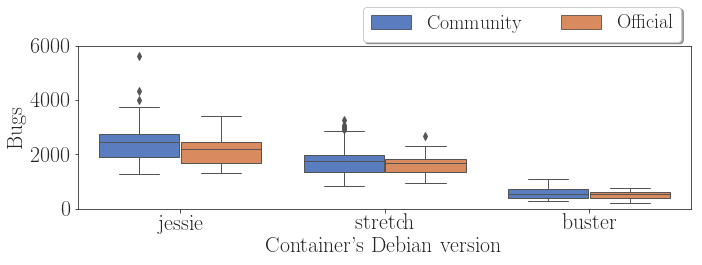

In [16]:
######### concatinating both dataframes : offical and community
if True:
    df_tmp=(lag_bug_all.
            groupby(['name','debian','type']).
            count().
            sort_values('source', ascending=False).
            reset_index()
           )

order=['jessie','stretch','buster']

ax = sns.boxplot(x="debian", y="source", data=df_tmp, hue="type", palette="muted", order=order, linewidth=1)
ax.figure.set_size_inches(11,3)
ax.set_xlabel("Container's Debian version")
ax.set_ylabel('Bugs')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.set_ylim(0,6000)

In [17]:
print(df_tmp.source.min(),
      df_tmp.source.median(),
     df_tmp.source.max())

213 2163.0 5628


In [18]:
for x in ['jessie','stretch','buster']:
    print(x)
    print(df_tmp.query('type=="Official"').query('debian=="'+x+'"').source.min(),
          df_tmp.query('type=="Official"').query('debian=="'+x+'"').source.median(),
          df_tmp.query('type=="Official"').query('debian=="'+x+'"').source.max(),
      df_tmp.query('type=="Community"').query('debian=="'+x+'"').source.min(),
         df_tmp.query('type=="Community"').query('debian=="'+x+'"').source.median(),
    df_tmp.query('type=="Community"').query('debian=="'+x+'"').source.max())


jessie
1307 2201.0 3415 1296 2450.0 5628
stretch
962 1683.0 2665 828 1759.0 3285
buster
213 560.0 776 278 561.0 1098


In [19]:
for x in ['jessie','stretch','buster']:
    print(x)
    cliffsDelta(df_tmp.query('type=="Community"').query('debian=="'+x+'"').source, 
            df_tmp.query('type=="Official"').query('debian=="'+x+'"').source)

jessie
d=0.28192800452586636
stretch
d=0.13625542803970223
buster
d=0.13015503875968992


In [22]:
if True:
    df_tmp=(lag_bug_all.
            groupby(['name','debian','type']).
            count().
            loc[:,['source']].
            reset_index()
           )
    df_tmp2=(lag_bug_all.query('isOutdate=="Out-of-date"').
             groupby(['name','debian','type','source','source_version']).
             count().
             reset_index().
             groupby(['name','debian','type']).
             count().
             reset_index().
             loc[:,['severity','name']]
            )
    
    df_tmp3=(df_tmp2.merge(
        df_tmp,
        left_on='name',
        right_on='name',
        how='left')
            )
df_tmp3['severity']=df_tmp3['severity'].apply(int)

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


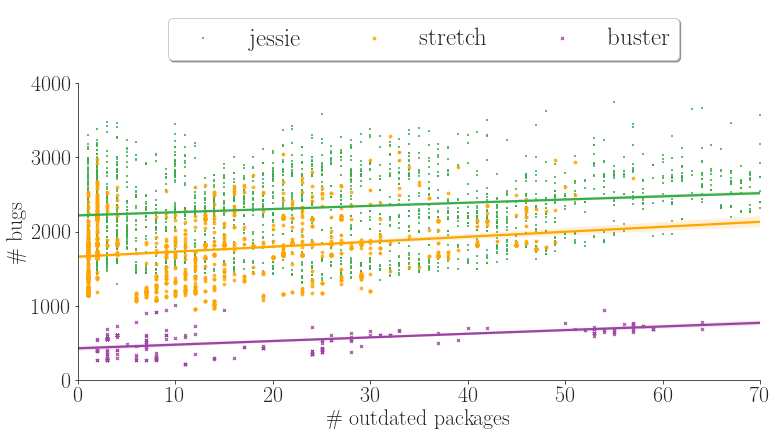

In [37]:
order=['jessie','stretch','buster']
ax = sns.lmplot(x="severity", y="source", markers=["+", 'o','x'], 
                hue="debian", palette=flatui, data=df_tmp3, scatter_kws={"s": 8},
                size=8, legend='', hue_order=order)
ax.fig.set_size_inches(12,5)
ax.set_ylabels('\# bugs')
ax.set_xlabels('\# outdated packages')
ax.fig.legend(loc='upper right', bbox_to_anchor=(0.8, 1.2), fontsize=25, fancybox=True, shadow=True,ncol=3)
ax.set(xlim=(0,70), ylim=(0,4000))
ax.fig.savefig('/home/neglectos/Desktop/thesis/Figs/docker/bugs_outdate.pdf', bbox_inches='tight', facecolor='white')


In [22]:
print('Up to date and only Resolved')
for x in ['jessie','stretch','buster']:
    test=df_tmp3.query('debian=="'+x+'"')
    print(x,scipy.stats.pearsonr(test.source, test.severity),'\n')
    
for x in ['jessie','stretch','buster']:
    test=df_tmp3.query('debian=="'+x+'"')
    print(x,scipy.stats.spearmanr(test.source, test.severity),'\n')
    
for x in ['jessie','stretch','buster']:
    test=df_tmp3.query('debian=="'+x+'"')
    print(x,scipy.stats.kendalltau(test.source, test.severity),'\n')

Up to date and only Resolved
jessie (0.1772566916045922, 8.0353002382872612e-35) 

stretch (0.21848075494915659, 3.0820667055671476e-18) 

buster (0.58273443554826021, 3.1915529211800343e-22) 

jessie SpearmanrResult(correlation=0.11589185178499886, pvalue=1.1344861622091802e-15) 

stretch SpearmanrResult(correlation=0.23180916298328011, pvalue=2.1596133643340471e-20) 

buster SpearmanrResult(correlation=0.55548721476885898, pvalue=6.1140388617119719e-20) 

jessie KendalltauResult(correlation=0.084513955519226303, pvalue=9.3680100269981785e-18) 

stretch KendalltauResult(correlation=0.15990059285439026, pvalue=1.3558733634041004e-19) 

buster KendalltauResult(correlation=0.42300241408150202, pvalue=1.867771708060768e-20) 



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


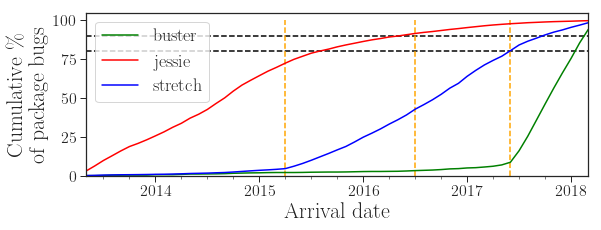

In [23]:
# When bugs were created
if True:
    df_tmp=docker_bugs.query('arrival>"2013-05-01"')
    df_tmp['arrival']=df_tmp['arrival'].apply(lambda x: x[0:7]+'-01' )
if True:
    df_tmp2=(df_tmp.
            loc[:,['arrival','release','debianbug']])
    df_tmp2.drop_duplicates(inplace=True)
    df_tmp2=df_tmp2.groupby(['arrival','release']).count().reset_index()
    
dff=(df_tmp2.
    pivot(index='arrival', columns='release', values='debianbug').
    fillna(0).
    reset_index().
    sort_values('arrival', ascending=True))

dff['arrival']=dff['arrival'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
dff.set_index('arrival', inplace=True)

for x in dff:
    dff[x]=dff[x].cumsum()
    max=dff[x].values.max()
    dff[x]=dff[x]*100/max
    
ax=dff.plot( color=['green','red','blue'])
ax.hlines(80, pd.to_datetime('2013-05-01'), pd.to_datetime('2018-03-01'), colors='black', linestyles='dashed', alpha=1)
ax.hlines(90, pd.to_datetime('2013-05-01'), pd.to_datetime('2018-03-01'), colors='black', linestyles='dashed', alpha=1)

ax.set_ylim(0,)
ax.set_ylabel('Cumulative \% \n of package bugs')
ax.set_xlabel('Arrival date')
ax.figure.set_size_inches(9,3)
plt.tick_params(axis='both', which='major', labelsize=16, width=1)
L=plt.legend(loc='upper left', prop={'size': 18})
plt.setp(L.texts, family='Consolas')

ax.set_xlim(pd.to_datetime('2013-05-01'), pd.to_datetime('2018-03-17'))
ax.vlines(pd.to_datetime('2015-04-25'), 0,100, colors='orange', linestyles='dashed', alpha=1)
ax.vlines(pd.to_datetime('2017-06-18'), 0,100, colors='orange', linestyles='dashed', alpha=1)
ax.vlines(pd.to_datetime('2016-07-01'), 0,100, colors='orange', linestyles='dashed', alpha=1)

In [24]:
vuls=docker_bugs.query('status=="fixed"')
vuls=vuls.groupby(['severity']).count().reset_index()
vuls['source']=(vuls['source']*100/len(docker_bugs.query('status=="fixed"'))).apply(lambda x: "%.1f" % x)
vuls

,severity,arrival,debianbug,last_modified,release,source,source_version,status,type
0,high,1048,1048,1048,1048,8.1,1048,1048,1048
1,important,3327,3327,3327,3327,25.9,3327,3327,3327
2,minor,832,832,832,832,6.5,832,832,832
3,normal,6159,6159,6159,6159,47.9,6159,6159,6159
4,wishlist,1497,1497,1497,1497,11.6,1497,1497,1497
